---
title: 2D Poisson
short_title: 
date: 2023-02-21
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: PDE, ODE, TimeStepper, Diffrax
---

This tutorial comes from the following resources:

* 12 Steps to Navier-Stokes - 2D Burgers -[ipynb](https://nbviewer.org/github/barbagroup/CFDPython/blob/master/lessons/10_Step_8.ipynb)
* JupyterBook on Iterative Models - [jbook](https://aquaulb.github.io/book_solving_pde_mooc/solving_pde_mooc/notebooks/05_IterativeMethods/05_02_Conjugate_Gradient.html)

**My Notes**:

* I had some serious stability issues from the time stepper. The CFL Condition is important!
* The code started to get a bit cumbersome, so I used a custom state + abstract functions.

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import numpy as np
import numba as nb
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from jaxsw._src.domain.base import Domain
from jaxsw._src.models.pde import DynamicalSystem
from jaxsw._src.domain.time import TimeDomain
from jaxsw._src.utils.linear_solver import steepest_descent, conjugate_gradient

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

Let's start with a simple 2D Diffusion scheme. This PDE is defined as:

$$
\begin{aligned}
\frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial y^2} = 0
\end{aligned}
$$ (eq:2d_laplace)

Here, we are advised to use a 2nd order accuracy central difference method. 

However, this is a PDE with no time dependence. We have a minimization problem where we want the best $p$ that solves the PDE. More concretely, we have

$$
\begin{aligned}
p^* &= \underset{p}{\text{argmin }}\mathcal{U}(p) \\
&\text{s.t.}\hspace{3mm}\mathcal{U}(p):=\nabla^2p = 0
\end{aligned}
$$

So we need to iteratively solve for this. Basically we will do:

```python
p_0 = ...
p_* = FixedPoint(p_0)
```

## Domain

In [104]:
# nx, ny = 101, 101
# xmin, ymin = 0.0, -0.5
# xmax, ymax = 1.0, 0.5
# Lx, Ly = xmax -xmin, ymax -ymin

nx, ny = 50, 50
xmin, xmax = 0, 2
ymin, ymax = 0, 1

In [105]:
domain = Domain.from_numpoints(xmin=(xmin, ymin), xmax=(xmax, ymax), N=(nx, ny))

print(f"Size: {domain.size}")
print(f"nDims: {domain.ndim}")
print(f"Grid Size: {domain.grid.shape}")
print(f"Cell Volume: {domain.cell_volume}")

Size: (51, 51)
nDims: 2
Grid Size: (51, 51, 2)
Cell Volume: 0.0008329862557267803


In [106]:
domain.xmin

(0, 0)

### Initial Conditions

We're doing a very specific initialization which is defined as:

$$
\begin{aligned}
\mathcal{IC}[p] &=
\begin{cases}
0 && \text{for }x=0\\
y && \text{for }x=2\\
\end{cases} \\
\mathcal{IC}\left[\frac{\partial p}{\partial y}\right] &=
0 && \text{for }y=0,1
\end{aligned}
$$


In [107]:
def init_u0(domain):
    """Initial condition from grid"""
    nx, ny = domain.size
    u = jnp.zeros((nx, ny), dtype=jnp.float64)

    return u

In [108]:
# def source(domain):
#     xmin, ymin = domain.xmin
#     xmax, ymax = domain.xmax
#     Lx, Ly = xmax - xmin, ymax - ymin

#     b = (
#         -2.0 * (jnp.pi/Lx) * (jnp.pi/Ly) *
#         jnp.sin(jnp.pi * domain.grid[...,0] / Lx) *
#         jnp.cos(jnp.pi * domain.grid[...,1] / Ly)
#     )
#     return b


def source(domain):
    nx, ny = domain.size
    b = jnp.zeros((nx, ny))

    b = b.at[int(nx / 4), int(ny / 4)].set(100)
    b = b.at[int(3 * nx / 4), int(3 * ny / 4)].set(-100)
    return b

In [109]:
b = source(domain)
b.shape

(51, 51)

In [110]:
u_init = init_u0(domain)

In [111]:
grid = domain.grid

In [112]:
u_init.shape

(51, 51)

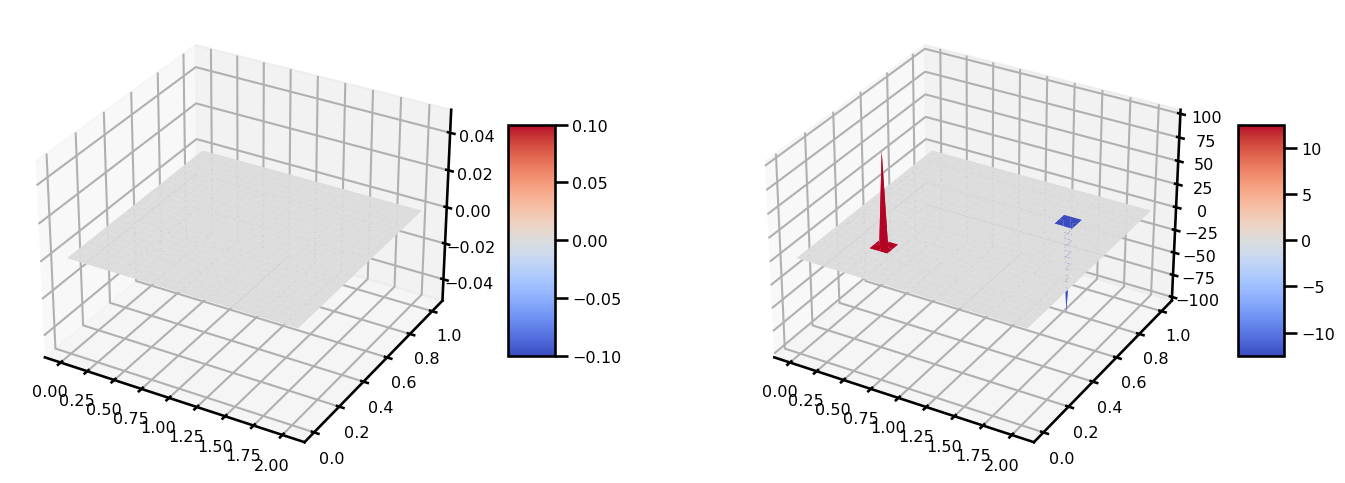

In [113]:
from matplotlib import cm

fig, ax = plt.subplots(ncols=2, figsize=(15, 5), subplot_kw={"projection": "3d"})
surf = ax[0].plot_surface(grid[..., 0], grid[..., 1], u_init, cmap=cm.coolwarm)
plt.colorbar(surf, shrink=0.5, aspect=5)
surf = ax[1].plot_surface(grid[..., 0], grid[..., 1], b, cmap=cm.coolwarm)
plt.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()

In [114]:
domain.size

(51, 51)

### Boundary Conditions

We are using the same boundary conditions as before, 1's everywhere. 

$$
\begin{aligned}
\mathcal{BC}[u](\mathbf{x}) = \mathcal{BC}[v](\mathbf{x})&= 1 
&& && \mathbf{x}\in\partial\Omega
\end{aligned}
$$

Note, we use the same BCs for both $u$ and $v$.

In [115]:
def bc_fn(u: Array) -> Array:
    u = u.at[0, :].set(0.0)
    u = u.at[-1, :].set(0.0)
    u = u.at[-2, :].set(0.0)
    u = u.at[:, 0].set(0.0)
    u = u.at[:, -2].set(0.0)
    u = u.at[:, -1].set(0.0)
    return u

### Equation of Motion

Because we are doing advection, we will use backwards difference for each of the terms.

$$
\begin{aligned}
D^-{2}_x[u] &:= \frac{\partial^2 u}{\partial x^2} \\
D^-{2}_y[u] &:= \frac{\partial^2 u}{\partial y^2} 
\end{aligned}
$$ (eq:2dnadvection)

where $D^2$ is the 2nd order accurate central difference method.

It's starting to get a bit cumbersome to put everything into a single equation, so we will start making functions for each other terms.

#### State

So for the "state", we need access to 2 variables and 1 constant: $u$, $v$, $\nu$. So we will create a "container" to hold these objects. A natural option is to use a NamedTuple. This is an immutable object that we can just use to pass around.

**Bonus**: Notice I used a nice python trick to create the state using a convenience function. This particular function initializes the state from a function that we pass through it.

In [116]:
from typing import Optional, NamedTuple, Callable


class State(NamedTuple):
    u: Array
    domain: Domain

    @classmethod
    def init_state(cls, domain, init_f: Callable):
        u = init_u0(domain)

        return cls(u=u, domain=domain)

    @staticmethod
    def update_state(state, u=None, domain=None):
        return State(
            u=u if u is not None else state.u,
            domain=domain if domain is not None else state.domain,
        )

In [117]:
state_init = State.init_state(domain, init_u0)

# update state (manually)
state_update = State(u=state_init.u, domain=state_init.domain)

# update state (convenience function)
state_update_ = State.update_state(state_init, u=state_init.u)

assert state_update == state_update_

#### Laplacian Equation

We have the advection term for both $u$ and $v$:

$$
\begin{aligned}
\frac{\partial u}{\partial t} &+ 
u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} = 0 \\
\frac{\partial v}{\partial t} &+ 
u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} = 0
\end{aligned}
$$

They recommend that we use the 1st order accurate backward difference scheme. We will make a generic advection function term that should work for both $u$ and $v$.

In [118]:
def equation_of_motion(u: Array, domain: Domain) -> Array:
    """Generic RHS of 2D Laplacian Equation

    Equation:
        ∂²u/∂x² + ∂²u/∂y²
    """

    u_lap = fdx.laplacian(
        u, step_size=(domain.dx[0], domain.dx[1]), accuracy=1, method="central"
    )

    u_lap = bc_fn(u_lap)

    return u_lap

### Iterative Methods


**Conditions**:

1) Max Iterations are completed
2) Our criteria is met!


#### Criteria

**L1-Norm**

$$
||u||_1 = \frac{\sum_{i=0,j=0}^k|u_{i,j}^{k+1}-u_{i,j}^k|^2}{\sum_{i=0,j=0}^k|u_{i,j}^k|^2}
$$


**L2-Norm**

$$
||u||_2 = \frac{\sqrt{\sum_{i=0,j=0}^k|u_{i,j}^{k+1}-u_{i,j}^k|^2}}{\sqrt{\sum_{i=0,j=0}^k|u_{i,j}^k|^2}}
$$

### Steepest Descent

In [119]:
target_criterion = 1e-4
max_iterations = 10_000
criterion = "l2"
u = init_u0(domain).copy()
b = source(domain)

matvec_fn = ft.partial(equation_of_motion, domain=domain)

out = steepest_descent(
    b=b,
    matvec_fn=matvec_fn,
    u_init=u,
    target_criterion=target_criterion,
    max_iterations=max_iterations,
    criterion=criterion,
)
out.iteration, out.loss

(Array(1104, dtype=int64, weak_type=True),
 Array(9.97729041e-05, dtype=float64))

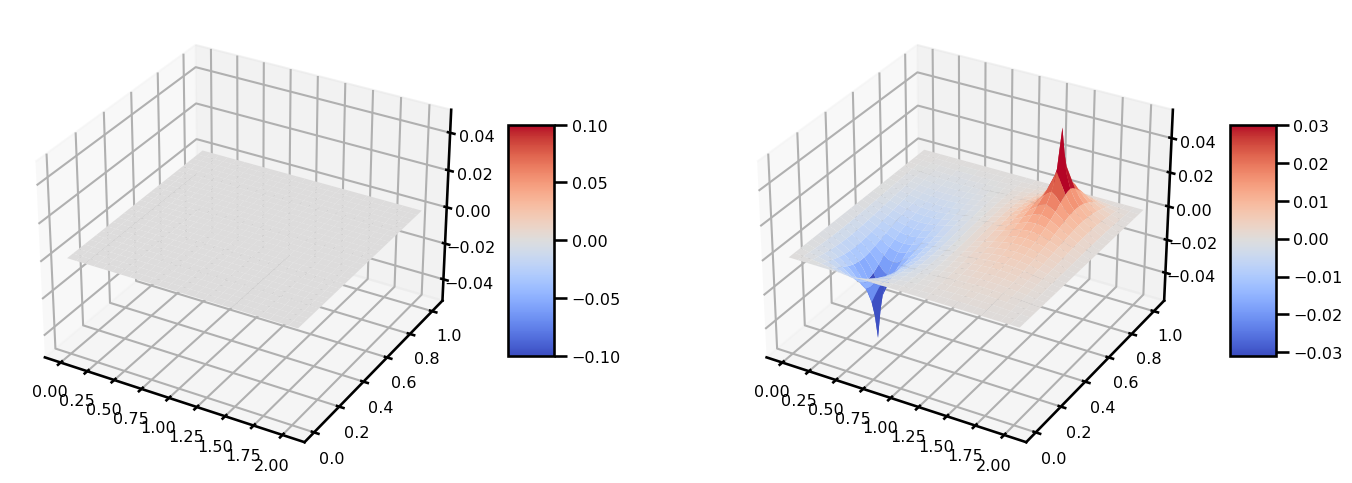

In [120]:
from matplotlib import cm

fig, ax = plt.subplots(ncols=2, figsize=(15, 5), subplot_kw={"projection": "3d"})

surf = ax[0].plot_surface(grid[..., 0], grid[..., 1], u, cmap=cm.coolwarm)
plt.colorbar(surf, shrink=0.5, aspect=5)
surf = ax[1].plot_surface(grid[..., 0], grid[..., 1], out.u, cmap=cm.coolwarm)
plt.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()

### Conjugate Gradient

In [121]:
import functools as ft


target_criterion = 1e-4
max_iterations = 1000
criterion = "l2"
u = init_u0(domain).copy()
b = source(domain)

matvec_fn = ft.partial(equation_of_motion, domain=domain)

out = conjugate_gradient(
    b=b,
    matvec_fn=matvec_fn,
    u_init=u,
    target_criterion=target_criterion,
    max_iterations=max_iterations,
    criterion=criterion,
)
out.iteration, out.loss

(Array(96, dtype=int64, weak_type=True), Array(8.55796368e-05, dtype=float64))

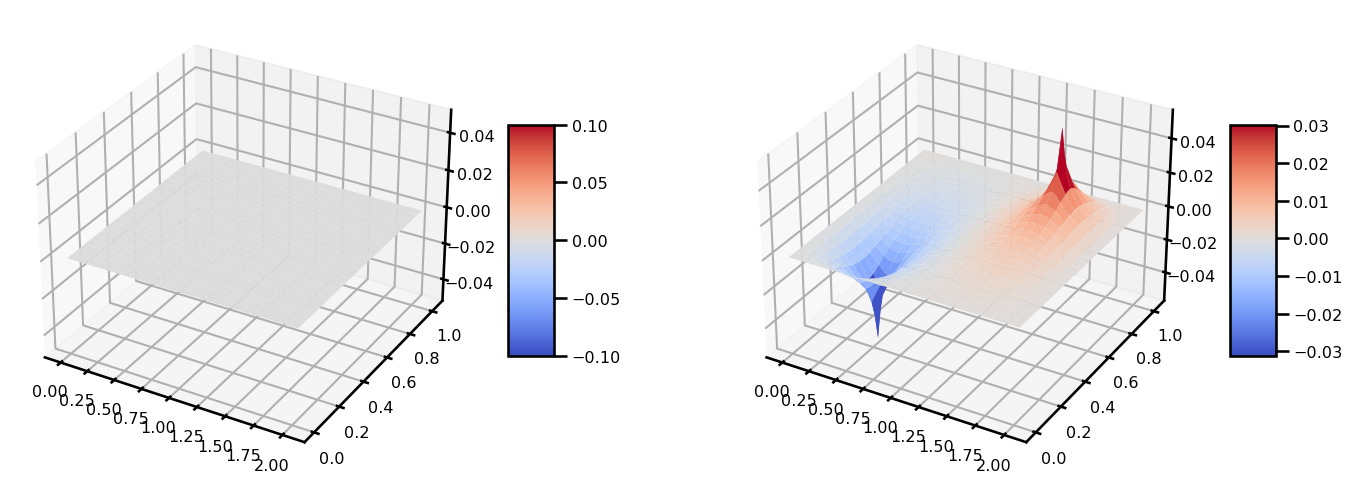

In [122]:
from matplotlib import cm

fig, ax = plt.subplots(ncols=2, figsize=(15, 5), subplot_kw={"projection": "3d"})

surf = ax[0].plot_surface(grid[..., 0], grid[..., 1], u, cmap=cm.coolwarm)
plt.colorbar(surf, shrink=0.5, aspect=5)
surf = ax[1].plot_surface(grid[..., 0], grid[..., 1], out.u, cmap=cm.coolwarm)
plt.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()

### Conjugate Gradient with JaxOpt

In [123]:
from jaxopt import linear_solve

b = source(domain)
u_init = init_u0(domain)

u_out = linear_solve.solve_cg(matvec=matvec_fn, b=b, init=u_init, maxiter=100, tol=1e-5)

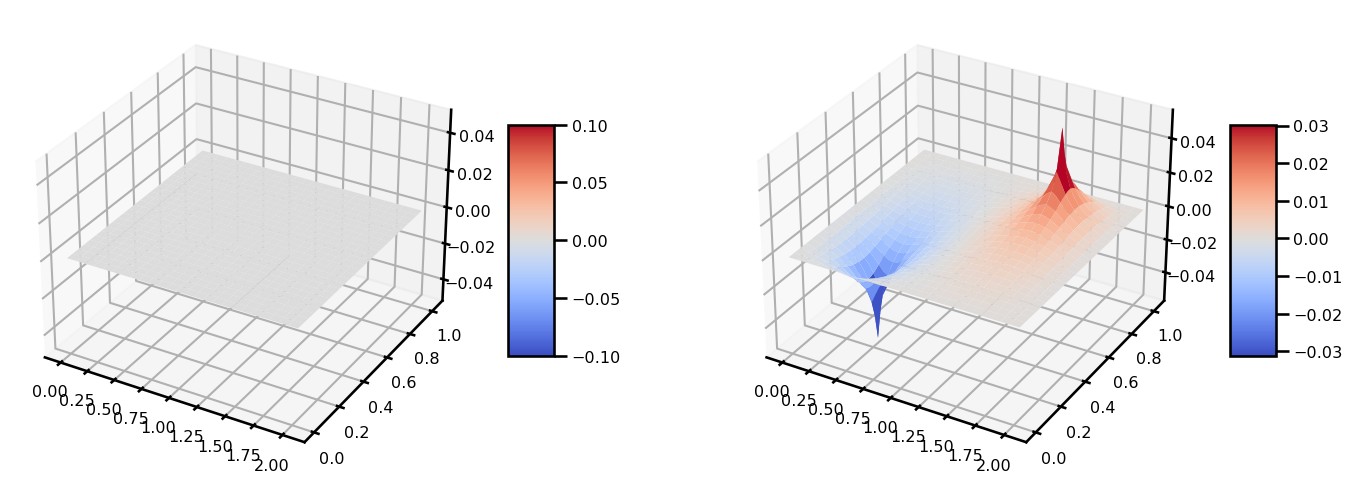

In [124]:
from matplotlib import cm

fig, ax = plt.subplots(ncols=2, figsize=(15, 5), subplot_kw={"projection": "3d"})
surf = ax[0].plot_surface(grid[..., 0], grid[..., 1], u_init, cmap=cm.coolwarm)
plt.colorbar(surf, shrink=0.5, aspect=5)
surf = ax[1].plot_surface(grid[..., 0], grid[..., 1], u_out, cmap=cm.coolwarm)
plt.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()